# Create plots for panels used in figure 3

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings('ignore')

In [2]:
# folder to save all panels for figure
savefolder = r"plots\fig3"

# file containing the data for the controls
results_ctrl_file = r"data\shape_analysis\histograms_HealthyControl_deformed_undeformed.txt"

In [3]:
#define a color seed for each patient
color_dict = {'VS': 'C0', 'VL': 'C1', 'RS': 'C2',
              'KM': 'C3', 'LM': 'C4'}

In [4]:
def asymptotic_exponential_growth(x, lambda_):
    """(Inverted) exponential growth function with maximum at 1 for x->infinity:
    f(x) = 1 - exp(-lambda * x)"""
    return 1 - np.exp(-lambda_ * x)

def deformed_probability_curve(df, v_min=0, v_max=3, binsize=.25):
    """Compute the values for the shape probability diagram to find a cell
    in a deformed state for velocities between v_min and v_max in the DataFrame df

    returns: *tuple* (deformed_bins, deformed_hist_normal)
        - deformed_bins: *array* limits for the bin ranges of the histogram
        - normalized counts for each velocity range
    """

    bins = int(v_max/binsize)   #number of Bins in histogram
    #find index of cells in a deformed state. Class definitions are:
    #1-parachute, 2-slipper, 3-asym. parachute, 5-multilobe, 7-undefined deformed
    #4-discocyte/undeformed, 6-tumbler
    deformed_index = ((df['shape'] == 1)
                      | (df['shape'] == 2)
                      | (df['shape'] == 3)
                      | (df['shape'] == 5)
                      | (df['shape'] == 7))

    #create new column in df that is True for deformed state
    df['deformed'] = False
    df['deformed'][deformed_index] = True

    df_deformed = df[deformed_index]

    deformed_hist, deformed_bins = np.histogram(np.array(df_deformed['velocity']),
                                                range = (v_min,v_max),
                                                bins = bins)
    #get the counts for all events to use for normalization
    all_hist, all_bins = np.histogram(np.array(df['velocity']),
                                      range = (v_min,v_max),
                                      bins = bins)

    #normalize the deformed histogram
    deformed_hist_normal = deformed_hist/all_hist

    return deformed_bins, deformed_hist_normal

In [5]:
#define dict to store fit values
dict_fitvalues = {}

def dict_fit_values_patient(patient, dict_fitvalues):
    result_summary_folder = r"data\shape_analysis\result_summaries"

    v_min = 0.
    v_max = 3.
    binsize = 0.25

    # bounds of the parameters in the exponential growth function
    fit_bounds=(0, np.inf)

    result_file = os.path.join(result_summary_folder, patient + "_results_MCFM.tsv")
    df_results = pd.read_csv(result_file, sep='\t')

    dates = np.unique(df_results['date'])
    dates = np.sort(dates)
    day0 = pd.to_datetime(dates[0])

    #create dataframes to save fit parameters
    df_fit_all = pd.DataFrame()
    df_fit_healthy = pd.DataFrame()
    df_fit_unhealthy = pd.DataFrame()

    for num, date in enumerate(dates):
        df_date = df_results[df_results['date']==date]
        #create new Dataframe to work with, leave out skipped cells
        df = df_date[df_date['shape'] != 0]

        healthy_index = df['health'] == 0
        df_healthy = df[healthy_index]
        unhealthy_index = df['health'] == 1
        df_unhealthy = df[unhealthy_index]

        #calculate percentage of healthy cells in sample
        percentage_healthy = len(df_healthy)/len(df)

        bins, deformed_curve = deformed_probability_curve(df, v_min=v_min, v_max=v_max, binsize=binsize)
        bins_healthy, deformed_curve_healthy =  deformed_probability_curve(df_healthy,
                                                                           v_min=v_min, v_max=v_max, binsize=binsize)
        bins_unhealthy, deformed_curve_unhealthy =  deformed_probability_curve(df_unhealthy,
                                                                               v_min=v_min, v_max=v_max, binsize=binsize)

        bins_plot = bins[:-1]+binsize/2

        #exclude nan values before fitting
        ind_nonnan_all = ~np.isnan(deformed_curve)
        ind_nonnan_healthy = ~np.isnan(deformed_curve_healthy)
        ind_nonnan_unhealthy = ~np.isnan(deformed_curve_unhealthy)

        x_all = bins_plot[ind_nonnan_all]
        y_all = deformed_curve[ind_nonnan_all]
        x_healthy = bins_plot[ind_nonnan_healthy]
        y_healthy = deformed_curve_healthy[ind_nonnan_healthy]
        x_unhealthy = bins_plot[ind_nonnan_unhealthy]
        y_unhealthy = deformed_curve_unhealthy[ind_nonnan_unhealthy]

        popt_all_exp, pcov_all_exp = curve_fit(asymptotic_exponential_growth,
                                               x_all, y_all,
                                               bounds=fit_bounds
                                               )
        popt_healthy_exp, pcov_healthy_exp = curve_fit(asymptotic_exponential_growth,
                                                       x_healthy, y_healthy,
                                                       bounds=fit_bounds
                                                       )
        popt_unhealthy_exp, pcov_unhealthy_exp = curve_fit(asymptotic_exponential_growth,
                                                           x_unhealthy, y_unhealthy,
                                                           bounds=fit_bounds
                                                           )
        #days since treatment start
        treatment_days = (pd.to_datetime(date) - day0).days

        df_fit_all = df_fit_all.append({'lambda': popt_all_exp[0], 'lambda_err': np.sqrt(pcov_all_exp[0,0]),
                                        'days': treatment_days,
                                        'percent healthy': percentage_healthy
                                        },
                                       ignore_index=True)
        df_fit_healthy = df_fit_healthy.append({'lambda': popt_healthy_exp[0], 'lambda_err': np.sqrt(pcov_healthy_exp[0,0]),
                                                'days': treatment_days
                                                },
                                               ignore_index=True)
        df_fit_unhealthy = df_fit_unhealthy.append({'lambda': popt_unhealthy_exp[0], 'lambda_err': np.sqrt(pcov_unhealthy_exp[0,0]),
                                                    'days': treatment_days
                                                    },
                                                   ignore_index=True)

    dict_fitvalues[patient] = {'all': df_fit_all, 'healthy': df_fit_healthy, 'unhealthy': df_fit_unhealthy}

    return dict_fitvalues

Fill dictionary with patient data

In [6]:
patients = ['LM', 'KM']
labels = ["P4", "P5"]

for patient in patients:
    dict_fitvalues = dict_fit_values_patient(patient, dict_fitvalues)

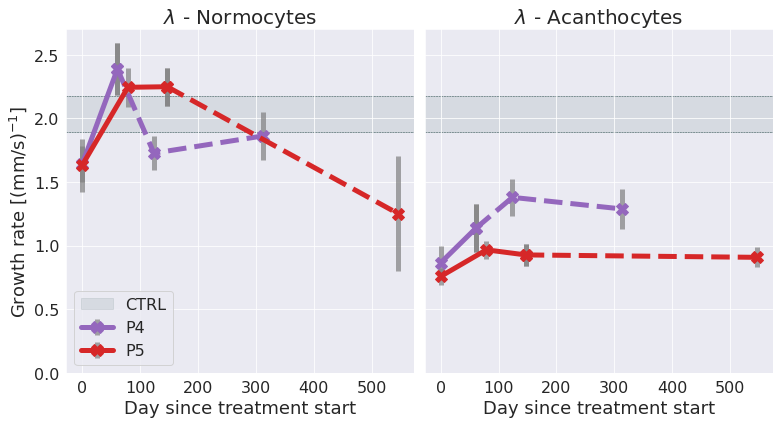

In [33]:
# plot variables
fontsize = 18
linewidth = 5
markersize = 12
errbar_width = 5
xlabel = 'Day since treatment start'

# color for the control interval
ctrl_clr = 'darkslategray'

# compute control fit values
results_ctrl = np.loadtxt(results_ctrl_file)

v_ctrl = results_ctrl[:,0]
probs_ctrl = results_ctrl[:,3]
probs_ctrl_err = results_ctrl[:,4]

v_min = 0.
v_max = 3.
binsize = 0.25
bins = int(v_max / binsize)

ind_vmax = v_ctrl <= v_max
v_ctrl = v_ctrl[ind_vmax]
probs_ctrl = probs_ctrl[ind_vmax]
probs_ctrl_err = probs_ctrl_err[ind_vmax]

fit_bounds = [0, np.inf]
popt_ctrl, pcov_ctrl = curve_fit(asymptotic_exponential_growth, v_ctrl, probs_ctrl,
                                 sigma = probs_ctrl_err, absolute_sigma=False,
                                 bounds=fit_bounds
                                 )
perr_ctrl = np.sqrt(np.diag(pcov_ctrl))

# limits of the 95% confidence interval
ci_lower = float(popt_ctrl - perr_ctrl)
ci_upper = float(popt_ctrl + perr_ctrl)

with sns.axes_style('darkgrid'):

    fig = plt.figure(0,(11,6))

    plot_titles = ['Normocytes', 'Acanthocytes']
    para = 'lambda'
    para_label = r'$\lambda$'
    ylim = [0, 2.7]

    for jj, patient in enumerate(patients):
        data = dict_fitvalues[patient]
        color = color_dict[patient]

        for n, health in enumerate(['healthy', 'unhealthy']):
            ax=plt.subplot(1,2,n+1)

            df_plot = data[health]
            xdata = df_plot['days']
            ydata = df_plot[para]
            yerr = df_plot[para + "_err"]

            if patient=='LM':
                # plot data on treatment
                plt.errorbar(xdata[:-2], ydata[:-2], yerr=yerr[:-2],
                             c=color, label=labels[jj],
                             ls='-', lw=linewidth, marker='X', markersize=markersize,
                             ecolor='gray', elinewidth=errbar_width)
                # plot data off treatment
                plt.errorbar(xdata[-3:], ydata[-3:], yerr=yerr[-3:],
                             c=color, #label=labels[jj],
                             ls='--', lw=linewidth, marker='X', markersize=markersize,
                             ecolor='gray', elinewidth=errbar_width)
            else:
                # plot data on treatment
                plt.errorbar(xdata[:-1], ydata[:-1], yerr=yerr[:-1],
                             c=color, label=labels[jj],
                             ls='-', lw=linewidth, marker='X', markersize=markersize,
                             ecolor='gray', elinewidth=errbar_width)
                # plot data off treatment
                plt.errorbar(xdata[-2:], ydata[-2:], yerr=yerr[-2:],
                             c=color, #label=labels[jj],
                             ls='--', lw=linewidth, marker='X', markersize=markersize,
                             ecolor='gray', elinewidth=errbar_width)

            plt.ylim(ylim)
            plt.xlabel(xlabel, fontsize=fontsize)
            plt.tick_params(axis='both', which='both', labelsize=fontsize-2)
            plt.xticks([0, 100, 200, 300, 400, 500])
            plt.title(r'{} - {}'.format(para_label, plot_titles[n]), fontsize=fontsize+2)

            # plot control region at end only
            if patient==patients[-1]:
                ax.axhline(ci_lower, ls='--', lw=.5, c=ctrl_clr, zorder=0)
                ax.axhline(ci_upper, ls='--', lw=.5, c=ctrl_clr, zorder=0)
                axis_limits = ax.get_xlim()
                ax.add_patch(patches.Rectangle((axis_limits[0], ci_lower),
                                               np.diff(axis_limits), ci_upper-ci_lower,
                                               color=ctrl_clr, alpha=0.1, zorder=0,
                                               label = 'CTRL'
                                               )
                             )
                # if health=='unhealthy':
                #     ax.get_yaxis().set_ticklabels([])

            # set alpha of errorbars
            for collection in ax.collections:
                collection.set_alpha(.7)

    ax1 = fig.axes[0]
    ax2 = fig.axes[1]

    ax2.get_yaxis().set_ticklabels([])
    ax1.legend(loc='lower left', ncol=1, fontsize=fontsize-2, title_fontsize=fontsize)
    fig.supylabel("Growth rate [(mm/s)$^{-1}$]", fontsize=fontsize)
    plt.tight_layout()
    # plt.subplots_adjust(wspace=.15)

    savename = "fig3_growth_rate_lithium"
    savepath = os.path.join(savefolder,savename)
    plt.savefig(savepath+".pdf", dpi=900, format='pdf')